---
title: "SRIP"
author: "Devansh Lodha"
date: "2025-26-02"
description: "We'll binarize images of Tom and Jerry, Pink Panther and some book pages. Then, we'll challenge Otsu's method with noisy inputs."
categories: [code, probability theory, image processing]
image: "image.png"
jupyter: python3
format: html
bibliography: references.bib
---

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt

## Data Exploration and Understanding

31 cm native resolution imagery. 
In total, there are 2,542 object labels following the same naming convention as the corresponding image chips.
The naming convention for all labels includes the name of the dataset, image type, tile identification number, minimum x bound, minimum y bound, and window size. 
The minimum bounds correspond to the origin of the chip in the full tile. An example label would be "solarpanels_native_1__x0_0_y0_6845_dxdy_416.txt," 
which is a label from native Tile 1 in the solar panel dataset, with a minimum x bound of 0, minimum y bound of 6845 and window size of 416 by 416 pixels. 
The corresponding image chip for this example would be "solarpanels_native_1__x0_0_y0_6845_dxdy_416.tif."

Labels are provided in .txt format where a single row in a label file contains the following information for one solar panel object: category, x-center, y-center, x-width, and y-width.  
Center and width values are normalized by chip sizes (416 by 416 pixels for native chips)
Each row in a label file corresponds to one object in the corresponding image chip. A single label file contains all of the object labels in the corresponding image chip.

The geocoordinates for each solar panel object may be determined using the native resolution labels (found in the labels_native directory). 
The center and width values for each object, along with the relative location information provided by the naming convention for each label, 
may be used to determine the pixel coordinates for each object in the full, corresponding native resolution tile. 
The pixel coordinates may be translated to geocoordinates using the EPSG:32633 coordinate system and the following geotransform for each tile:

Tile 1: (307670.04, 0.31, 0.0, 5434427.100000001, 0.0, -0.31)
Tile 2: (312749.07999999996, 0.31, 0.0, 5403952.860000001, 0.0, -0.31)
Tile 3: (312749.07999999996, 0.31, 0.0, 5363320.540000001, 0.0, -0.31)

In [3]:
images_path = "data/images"
labels_path = "data/labels"

### Dataset Statistics

We'll first calculate the total instances of solar panels in the dataset

In [4]:
total_instances = 0
labels_per_image = {}

for filename in os.listdir(labels_path):
    if filename.endswith(".txt"):
        filepath = os.path.join(labels_path, filename)
        with open(filepath, 'r') as f:
            lines = f.readlines()
            num_instances = len(lines)
            total_instances += num_instances
            labels_per_image[filename] = num_instances

print(f"Total instances of solar panels in the dataset: {total_instances}")

Total instances of solar panels in the dataset: 29625


Now we'll calculate value counts of labels per image

In [5]:
labels_counts = {}
for filename, count in labels_per_image.items():
    labels_counts[count] = labels_counts.get(count, 0) + 1

print("\nValue counts of labels per image:")
for count, num_images in sorted(labels_counts.items()):
    print(f"{num_images} images have {count} labels.")


Value counts of labels per image:
81 images have 1 labels.
167 images have 2 labels.
221 images have 3 labels.
218 images have 4 labels.
217 images have 5 labels.
189 images have 6 labels.
170 images have 7 labels.
184 images have 8 labels.
169 images have 9 labels.
121 images have 10 labels.
97 images have 11 labels.
84 images have 12 labels.
69 images have 13 labels.
49 images have 14 labels.
46 images have 15 labels.
41 images have 16 labels.
36 images have 17 labels.
25 images have 18 labels.
29 images have 19 labels.
14 images have 20 labels.
4 images have 21 labels.
1 images have 22 labels.
4 images have 23 labels.
2 images have 24 labels.
4 images have 25 labels.
3 images have 26 labels.
5 images have 27 labels.
5 images have 28 labels.
15 images have 29 labels.
20 images have 30 labels.
8 images have 31 labels.
7 images have 32 labels.
13 images have 33 labels.
19 images have 34 labels.
10 images have 35 labels.
6 images have 36 labels.
17 images have 37 labels.
13 images have

### Area of Solar Panels

To calculate the area of solar panels, we'll need to first convert the bounding boxes coordinates to their actual geographical coordinates.


Statistics of the area of solar panels in meters:
Mean area: 191.52 square meters
Standard deviation of area: 630.70 square meters


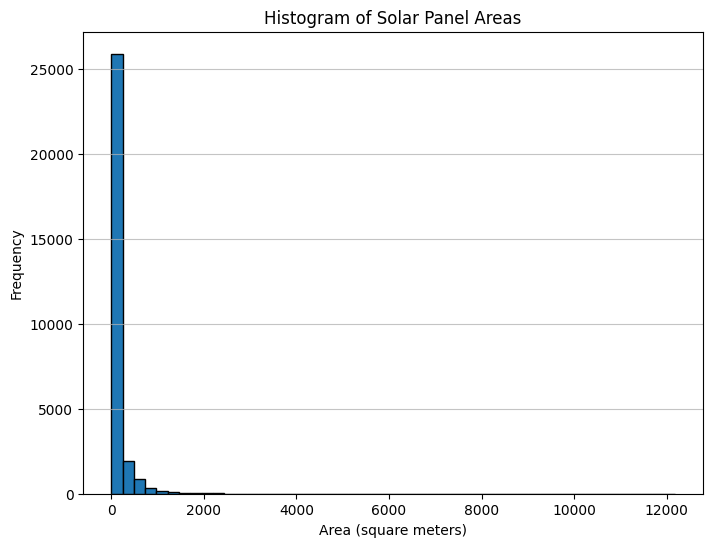

In [14]:
areas = []
geotransforms = {
    1: (307670.04, 0.31, 0.0, 5434427.100000001, 0.0, -0.31),
    2: (312749.07999999996, 0.31, 0.0, 5403952.860000001, 0.0, -0.31),
    3: (312749.07999999996, 0.31, 0.0, 5363320.540000001, 0.0, -0.31)
}
chip_size = 416

for filename in os.listdir(labels_path):
    if filename.endswith(".txt"):
        filepath = os.path.join(labels_path, filename)
        parts = filename.split('_')
        tile_num = int(parts[2])
        xmin_chip = int(parts[5])
        ymin_chip = int(parts[7])
        dxdy = int(parts[9].split('.')[0]) # window size
        
        geotransform = geotransforms[tile_num]
        with open(filepath, 'r') as f:
            for line in f:
                category, x_center_norm, y_center_norm, x_width_norm, y_width_norm = map(float, line.strip().split())

                # Normalized to pixel coords in chip (416x416)
                x_center_chip = x_center_norm * chip_size
                y_center_chip = y_center_norm * chip_size
                x_width_chip = x_width_norm * chip_size
                y_width_chip = y_width_norm * chip_size

                # Chip coords to tile coords
                xmin_tile_px = xmin_chip
                ymin_tile_px = ymin_chip
                x_center_tile = xmin_tile_px + x_center_chip
                y_center_tile = ymin_tile_px + y_center_chip
                x_width_tile = x_width_chip
                y_width_tile = y_width_chip

                # Pixel coords to geocoords (EPSG:32633)
                x_geo = geotransform[0] + x_center_tile * geotransform[1] + y_center_tile * geotransform[2]
                y_geo = geotransform[3] + x_center_tile * geotransform[4] + y_center_tile * geotransform[5]
                x_geo_width = x_width_tile * geotransform[1] # width in meters
                y_geo_height = y_width_tile * abs(geotransform[5]) # height in meters (geotransform[5] is negative)

                area = x_geo_width * y_geo_height
                areas.append(area)

print("\nStatistics of the area of solar panels in meters:")
print(f"Mean area: {np.mean(areas):.2f} square meters")
print(f"Standard deviation of area: {np.std(areas):.2f} square meters")

# Histogram of areas
plt.figure(figsize=(8, 6))
plt.hist(areas, bins=50, edgecolor='black')
plt.title('Histogram of Solar Panel Areas')
plt.xlabel('Area (square meters)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

The distribution is skewed, indicating that smaller solar panels are more frequent than larger ones.

## Implementing Fundamental Functions

In [19]:
from shapely.geometry import Polygon
import supervision as sv

### Intersection over Union (IoU)

#### Using Shapely

We use shapely's Polygon class to calculate the intersection over union of two bounding boxes. For this first we need a function to convert the bounding box coordinates to a polygon.

In [20]:
def yolo_to_polygon(box_yolo, img_w, img_h):
    _, x_center_norm, y_center_norm, width_norm, height_norm = box_yolo
    x_center = x_center_norm * img_w
    y_center = y_center_norm * img_h
    width = width_norm * img_w
    height = height_norm * img_h
    x_min = x_center - width / 2
    y_min = y_center - height / 2
    x_max = x_center + width / 2
    y_max = y_center + height / 2
    return Polygon([(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max)])

def iou_shapely(box1_yolo, box2_yolo, image_width, image_height):
    _, x_center1_norm, y_center1_norm, width1_norm, height1_norm = box1_yolo
    _, x_center2_norm, y_center2_norm, width2_norm, height2_norm = box2_yolo

    poly1 = yolo_to_polygon(box1_yolo, image_width, image_height)
    poly2 = yolo_to_polygon(box2_yolo, image_width, image_height)

    intersection_area = poly1.intersection(poly2).area
    union_area = poly1.union(poly2).area
    if union_area == 0:
        return 0.0
    return intersection_area / union_area

#### Using Supervision

sv.Detections expects coordinates in xyxy format

In [23]:
def yolo_to_xyxy(box_yolo, img_w, img_h):
    _, x_center_norm, y_center_norm, width_norm, height_norm = box_yolo
    x_center = x_center_norm * img_w
    y_center = y_center_norm * img_h
    width = width_norm * img_w
    height = height_norm * img_h
    x_min = x_center - width / 2
    y_min = y_center - height / 2
    x_max = x_center + width / 2
    y_max = y_center + height / 2
    return np.array([x_min, y_min, x_max, y_max])

def iou_supervision(box1_yolo, box2_yolo, image_width, image_height):
    box1_xyxy = yolo_to_xyxy(box1_yolo, image_width, image_height)
    box2_xyxy = yolo_to_xyxy(box2_yolo, image_width, image_height)

    detections1 = sv.Detections(xyxy=box1_xyxy[np.newaxis, :], confidence=np.array([1.0]), class_id=np.array([0]))
    detections2 = sv.Detections(xyxy=box2_xyxy[np.newaxis, :], confidence=np.array([1.0]), class_id=np.array([0]))

    iou_matrix = sv.box_iou_batch(detections1.xyxy, detections2.xyxy) # pairwise IoU between boxes
    return iou_matrix[0, 0] if iou_matrix.size > 0 else 0.0

#### Comparing IoUs

Use images from dataset here

In [25]:
image_size = 100
box1_yolo = [0, 0.5, 0.5, 0.2, 0.2] # category, x_center_norm, y_center_norm, x_width_norm, y_width_norm
box2_yolo = [0, 0.6, 0.6, 0.2, 0.2]

iou_shapely_val = iou_shapely(box1_yolo, box2_yolo, image_size, image_size)
iou_supervision_val = iou_supervision(box1_yolo, box2_yolo, image_size, image_size)

print(f"\nIoU using shapely: {iou_shapely_val:.4f}")
print(f"IoU using supervision: {iou_supervision_val:.4f}")


IoU using shapely: 0.1429
IoU using supervision: 0.1429


The IoU values from shapely and supervision are the same!

### Average Precision (AP)

#### Pascal VOC 11 point interpolation method

In [ ]:
def average_precision_voc11(precisions, recalls):
    """
    Calculates Average Precision using Pascal VOC 11-point interpolation.
    """
    voc_recall_points = np.linspace(0, 1, 11)
    interpolated_precisions = []
    for r in voc_recall_points:
        mask = recalls >= r
        if np.any(mask):
            interpolated_precisions.append(np.max(precisions[mask]))
        else:
            interpolated_precisions.append(0.0) # or could be np.nan, depending on handling
    return np.mean(interpolated_precisions)

#### COCO 101-point interpolation method

In [ ]:
def average_precision_coco101(precisions, recalls):
    """
    Calculates Average Precision using COCO 101-point interpolation.
    """
    coco_recall_points = np.linspace(0, 1, 101)
    interpolated_precisions = np.interp(coco_recall_points, recalls[::-1], precisions[::-1], left=0, right=0) #reverse to make recall increasing
    return np.mean(interpolated_precisions)

#### Area under Precision-Recall Curve (AP) method

In [ ]:
def average_precision_auc(precisions, recalls):
    """
    Calculates Average Precision using Area Under the Precision-Recall Curve (AUC).
    """
    return auc(recalls, precisions)

#### Comparing AP50s

In [ ]:
# Test AP functions with random boxes
def generate_random_detections(num_images=10, image_size=100, box_size=20):
    all_true_boxes = []
    all_pred_boxes = []
    all_scores = []
    for _ in range(num_images):
        true_boxes_img = []
        pred_boxes_img = []
        scores_img = []
        for _ in range(10): # 10 boxes per image
            # Ground truth box
            x_center_gt = random.uniform(0.2, 0.8) # center within image
            y_center_gt = random.uniform(0.2, 0.8)
            true_box = [0, x_center_gt, y_center_gt, box_size/image_size, box_size/image_size]
            true_boxes_img.append(true_box)

            # Predicted box (slightly shifted from GT for some overlap)
            x_center_pred = x_center_gt + random.uniform(-0.1, 0.1)
            y_center_pred = y_center_gt + random.uniform(-0.1, 0.1)
            pred_box = [0, max(0.01, min(0.99, x_center_pred)), max(0.01, min(0.99, y_center_pred)), box_size/image_size, box_size/image_size] # clamp to avoid boxes outside image
            pred_boxes_img.append(pred_box)
            scores_img.append(random.uniform(0.5, 1.0)) # Assign some confidence score

        all_true_boxes.append(true_boxes_img)
        all_pred_boxes.append(pred_boxes_img)
        all_scores.append(scores_img)
    return all_true_boxes, all_pred_boxes, all_scores

random_true_boxes, random_pred_boxes, random_scores = generate_random_detections()

def compute_ap_and_pr(true_boxes_list, pred_boxes_list, scores_list, iou_threshold=0.5, image_size=100):
    """Computes AP and PR curve data for a list of images with GT and predictions."""
    all_matches = []
    for true_boxes_img, pred_boxes_img, scores_img in zip(true_boxes_list, pred_boxes_list, scores_list):
        matches_img = []
        used_gt_boxes = [False] * len(true_boxes_img) # Track which GT boxes are matched

        # Sort predictions by confidence score (descending)
        pred_indices_sorted = np.argsort(scores_img)[::-1]
        sorted_pred_boxes = [pred_boxes_img[i] for i in pred_indices_sorted]

        for pred_box in sorted_pred_boxes:
            best_iou = 0
            best_gt_index = -1
            for gt_index, true_box in enumerate(true_boxes_img):
                if not used_gt_boxes[gt_index]: # Only consider unmatched GT boxes
                    iou = iou_shapely(true_box, pred_box, image_size, image_size)
                    if iou > best_iou:
                        best_iou = iou
                        best_gt_index = gt_index

            if best_iou > iou_threshold:
                matches_img.append(1.0) # TP
                used_gt_boxes[best_gt_index] = True # Mark GT box as used
            else:
                matches_img.append(0.0) # FP
        all_matches.append(matches_img)

    # Flatten matches and scores across all images
    flat_matches = np.concatenate(all_matches) if all_matches else np.array([])
    flat_scores = np.concatenate([scores_list[i] for i in range(len(scores_list))]) if scores_list else np.array([])

    # Calculate Precision and Recall
    if flat_matches.size > 0:
        tp_cumulative = np.cumsum(flat_matches)
        fp_cumulative = np.cumsum(1 - flat_matches)
        precision = tp_cumulative / (tp_cumulative + fp_cumulative)
        recall = tp_cumulative / len(np.concatenate(true_boxes_list)) if np.concatenate(true_boxes_list).size > 0 else np.zeros_like(precision) # Avoid division by zero if no GT boxes
        return precision, recall
    else:
        return np.array([1.0]), np.array([0.0]) # Handle case with no predictions

iou_threshold_ap50 = 0.5
precisions, recalls = compute_ap_and_pr(random_true_boxes, random_pred_boxes, random_scores, iou_threshold=iou_threshold_ap50)

ap_voc11 = average_precision_voc11(precisions, recalls)
ap_coco101 = average_precision_coco101(precisions, recalls)
ap_auc_val = average_precision_auc(precisions, recalls)

print(f"\nAP50 using Pascal VOC 11-point interpolation: {ap_voc11:.4f}")
print(f"AP50 using COCO 101-point interpolation: {ap_coco101:.4f}")
print(f"AP50 using PR-AUC: {ap_auc_val:.4f}")